

# **Partie 1 du projet: Détection des Fake News**


**Dans ce fichier, les premières étapes de notre projet de Détection de Fake News sont faites!
Ici on a analysé le jeu de données utilisé, qui est : [Fake News Challenge (FNC)](https://github.com/FakeNewsChallenge/fnc-1), on l'a prétraité ainsi qu'on a généré des modèles pour le résumé des articles de la base de données pour une haute performance de détection des fake news par nos futurs modèles.**

In [ ]:
# Importing general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import time
from pprint import pprint
from collections import Counter

# Importing libraries for data processing
from nltk import FreqDist, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Analyse Exploratoire des Données

In [ ]:
# Clonez le référentiel complet dans votre espace de stockage Colab
!git clone https://github.com/FakeNewsChallenge/fnc-1.git

# Changez le répertoire de travail vers le dossier cloné
%cd fnc-1


Cloning into 'fnc-1'...
remote: Enumerating objects: 49, done.
remote: Total 49 (delta 0), reused 0 (delta 0), pack-reused 49
Receiving objects: 100% (49/49), 5.60 MiB | 18.67 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/fnc-1/fnc-1


In [ ]:
#Les données sont déjà réparties en ensembles d'entraînement et de test.
train_headlines = pd.read_csv('train_stances.csv')
train_bodies = pd.read_csv('train_bodies.csv')
test_headlines = pd.read_csv('test_stances_unlabeled.csv')
test_bodies = pd.read_csv('test_bodies.csv')

### Investigation de l'ensemble d'entraînement

In [ ]:
train_headlines.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodies' near Mexico town where 43 students disappeared after police clash,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza as Israel opens dams,158,agree
2,"Christian Bale passes on role of Steve Jobs, actor reportedly felt he wasn't right for part",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV Streaming Service Launching in April,1034,unrelated
4,Spider burrowed through tourist's stomach and up into his chest,1923,disagree


In [ ]:
train_headlines.Headline.describe()

count                                             49972
unique                                             1648
top       ISIL Beheads American Photojournalist in Iraq
freq                                                127
Name: Headline, dtype: object

    count : Il y a un total de 49972 titres dans l'ensemble d'entraînement.

    unique : Il y a 1648 titres uniques, ce qui signifie qu'il y a 1648 titres différents parmi les 49972 titres.

    top : Le titre le plus fréquent dans l'ensemble d'entraînement est "L'État islamique décapite un photojournaliste américain en Irak", qui apparaît 127 fois.

    freq : La fréquence indique le nombre d'occurrences du titre le plus fréquent, qui est 127.

In [ ]:
#nombre d'occurrences pour chaque identifiant
train_headlines['Body ID'].value_counts()

1921    187
1948    175
40      172
524     171
1549    166
       ... 
16        1
65        1
114       1
24        1
1066      1
Name: Body ID, Length: 1683, dtype: int64

In [ ]:
train_bodies.head()

,Body ID,articleBody
0,0,"A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports. \n\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a ""relatively small"" meteorite that ""appears to have come off an asteroid that was passing close to Earth."" House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\n\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet, said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\n\nHumberto Garcia, of the Astronomy Center at the National Autonomous University of Nicaragua, said the meteorite could be related to an asteroid that was forecast to pass by the planet Saturday night.\n\n""We have to study it more because it could be ice or rock,"" he said.\n\nWilfried Strauch, an adviser to the Institute of Territorial Studies, said it was ""very strange that no one reported a streak of light. We have to ask if anyone has a photo or something.""\n\nLocal residents reported hearing a loud boom Saturday night, but said they didn't see anything strange in the sky.\n\n""I was sitting on my porch and I saw nothing, then all of a sudden I heard a large blast. We thought it was a bomb because we felt an expansive wave,"" Jorge Santamaria told The Associated Press.\n\nThe site of the crater is near Managua's international airport and an air force base. Only journalists from state media were allowed to visit it."
1,4,"Last week we hinted at what was to come as Ebola fears spread across America. Today, we get confirmation. As The Daily Caller reports, one passenger at Dulles International Airport outside Washington, D.C. is apparently not taking any chances. A female passenger dressed in a hazmat suit - complete with a full body gown, mask and gloves - was spotted Wednesday waiting for a flight at the airport.\n\n \n\n\n\nSource: The Daily Caller\n\nWe particularly liked the JCPenney bag - maybe that's a new business line for the bankrupt retailer...\n\n* * *\n\nOn a side note, try Halloween stores if you need a Haz-Mat suit in a hurry..."
2,5,"(NEWSER) – Wonder how long a Quarter Pounder with cheese can last? Two Australians say they bought a few McDonald's burgers for friends back in 1995, when they were teens, and one of the friends never showed up. So the kid's burger went uneaten—and stayed that way, Australia's News Network reports. ""We’re pretty sure it’s the oldest burger in the world,"" says one of the men, Casey Dean. Holding onto the burger for their friend ""started off as a joke,"" he adds, but ""the months became years and now, 20 years later, it looks the same as it did the day we bought it, perfectly preserved in its original wrapping.""\n\nDean and his burger-buying mate, Eduard Nitz, even took the burger on Australian TV show The Project last night and ""showed off the mold-free specimen,"" News 9 reports. The pair offered to take a bite of it for charity but were dissuaded by the show's hosts. They've also started a Facebook page for the burger called ""Can This 20 Year Old Burger Get More Likes Than Kanye West?"" that has more than 4,044 likes as of this writing. And they're selling an iTunes song, ""Free the Burger,"" for $1.69, and giving proceeds to the charity Beyond Blue, which helps Australians battle anxiety and depression. (A few years ago, a man sold a 20-year-old bottle of McDonald's McJordan sauce for $10,000. Here's why Mickey D's food seemingly never decays.)"
3,6,"Posting photos of a 

In [ ]:
train_bodies.articleBody.describe()

count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

    count : Il y a 1683 entrées dans cette colonne, ce qui signifie qu'il y a 1683 articles dans l'ensemble d'entraînement.

    unique : Parmi ces 1683 articles, seuls 1669 sont uniques. => certains articles se répètent, mais la plupart sont distincts.

    top: Le contenu le plus fréquent dans cette colonne est "French Apple website iGen.fr is reporting [Goo...".

    freq : La fréquence est le nombre d'occurrences de l'article le plus fréquent, qui est 2.

In [ ]:
set(train_bodies['Body ID']) == set(train_headlines['Body ID'])

True

=> il y a une correspondance entre les titres et les corps d'articles dans l'ensemble d'entrainement

### Investigation de l'ensemble de test

In [ ]:
test_headlines.head()

,Headline,Body ID
0,Ferguson riots: Pregnant woman loses eye after cops fire BEAN BAG round through car window,2008
1,Crazy Conservatives Are Sure a Gitmo Detainee Killed James Foley,1550
2,A Russian Guy Says His Justin Bieber Ringtone Saved Him From A Bear Attack,2
3,"Zombie Cat: Buried Kitty Believed Dead, Meows Back to Life",1793
4,Argentina's President Adopts Boy to End Werewolf Curse,37


In [ ]:
test_headlines.Headline.describe()

count                                           25413
unique                                            894
top       Source: Joan Rivers' doc did biopsy, selfie
freq                                              160
Name: Headline, dtype: object

In [ ]:
test_headlines['Body ID'].value_counts()

1373    161
2383    136
338     132
1639    123
1394    122
       ... 
71        1
127       1
102       1
287       1
590       1
Name: Body ID, Length: 904, dtype: int64

In [ ]:
test_bodies.head()

Body ID  \
0        1   
1        2   
2        3   
3       12   
4       19   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [ ]:
test_bodies.articleBody.describe()

count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
set(test_headlines['Body ID']) == set(test_bodies['Body ID'])

True

=> il y a une correspondance entre les titres et les corps d'articles dans l'ensemble de test

### Comptage des classes

In [ ]:
def number_of_classes(dataframe, column='Stance'):
    # Comptage du nombre d'occurrences de chaque classe dans la colonne spécifiée
    no_stances = Counter(dataframe[column])

    # Création d'un DataFrame à partir du dictionnaire des comptes
    stances_data = pd.DataFrame.from_dict(no_stances, orient='index')
    stances_data.columns = ['compte']

    # Tri du DataFrame en fonction du nombre d'occurrences (du plus grand au plus petit)
    stances_data = stances_data.sort_values(['compte'], ascending=False)

    # Calcul du nombre total d'occurrences pour calculer les pourcentages
    total_no_counts = 0
    for index, row in stances_data.iterrows():
        total_no_counts += row['compte']

    # Ajout d'une colonne pour les pourcentages d'occurrences
    stances_data['%comptes'] = round(stances_data['compte'] / total_no_counts * 100)

    # Tracé d'un graphique à barres du nombre d'occurrences pour chaque classe
    stances_data['compte'].plot(kind='bar')

    # Affichage du DataFrame avec les comptes et pourcentages
    print(stances_data)


           compte  %comptes
unrelated   36545      73.0
discuss      8909      18.0
agree        3678       7.0
disagree      840       2.0


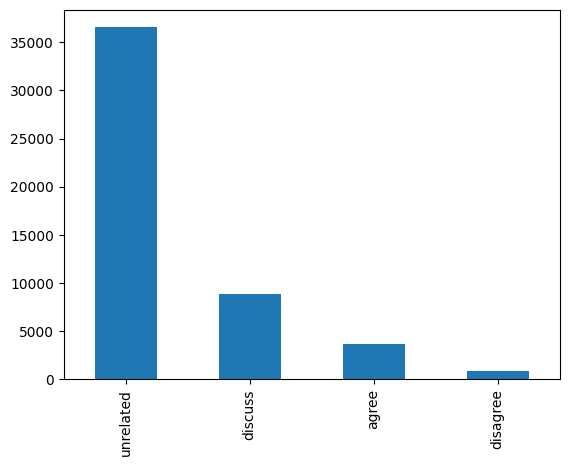

In [ ]:
number_of_classes(train_headlines)

    Le pourcentage (%comptes) indique la proportion de chaque classe par rapport au nombre total d'articles dans le jeu de données.
    Par exemple, "non lié" représente 73% de tous les articles dans le jeu de données.

    => Ces informations nous donnent un aperçu de la distribution des classes dans notre ensemble de données d'entraînement.
    Cela peut être utile pour comprendre la répartition des stances et pour adapter nos modèles en conséquence lors de la détection de fake news

# Prétraitement des données

In [ ]:
# Chargement des stopwords en anglais
f = open('/content/stopwords-en.txt', 'r')
english_stop_words = f.read().split('\n')
f.close()


In [ ]:
# Fonction de prétraitement de texte
def preprocessing(data, column):
    # Suppression des caractères non alphabétiques
    data['processed_' + column] = [re.sub("[^a-zA-Z]", " ", str(a)) for a in data[column]]

    # Tokenisation
    data['processed_' + column] = [word_tokenize(a) for a in data['processed_' + column]]

    # Conversion en minuscules et suppression des stopwords
    data['processed_' + column] = [
        ' '.join([w.lower() for w in a if w not in english_stop_words]) for a in data['processed_' + column]
    ]



*   On essaie dans le code ci-dessus d'assurer la **préparation** adéquate des données textuelles pour la détection de fake news en éliminant les caractères non alphabétiques, en normalisant le texte et en éliminant les stopwords.

=> cette section de code crée des représentations cohérentes et optimisées pour l'analyse des données.


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Application de la fonction de prétraitement aux données d'entraînement et de test
preprocessing(train_headlines, 'Headline')
preprocessing(train_bodies, 'articleBody')
preprocessing(test_headlines, 'Headline')
preprocessing(test_bodies, 'articleBody')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!pip install Ipython

In [ ]:
from IPython.display import display
pd.set_option('display.max_colwidth', None)
display(train_headlines.head())
display(train_bodies.head())

,Headline,Body ID,Stance,processed_Headline
0,Police find mass graves with at least '15 bodies' near Mexico town where 43 students disappeared after police clash,712,unrelated,police mass graves bodies mexico town students disappeared police clash
1,Hundreds of Palestinians flee floods in Gaza as Israel opens dams,158,agree,hundreds palestinians flee floods gaza israel dams
2,"Christian Bale passes on role of Steve Jobs, actor reportedly felt he wasn't right for part",137,unrelated,christian bale passes role steve jobs actor reportedly
3,HBO and Apple in Talks for $15/Month Apple TV Streaming Service Launching in April,1034,unrelated,hbo apple talks month apple tv streaming service launching april
4,Spider burrowed through tourist's stomach and up into his chest,1923,disagree,spider burrowed tourist stomach chest


,Body ID,articleBody,processed_articleBody
0,0,"A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports. \n\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a ""relatively small"" meteorite that ""appears to have come off an asteroid that was passing close to Earth."" House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\n\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet, said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\n\nHumberto Garcia, of the Astronomy Center at the National Autonomous University of Nicaragua, said the meteorite could be related to an asteroid that was forecast to pass by the planet Saturday night.\n\n""We have to study it more because it could be ice or rock,"" he said.\n\nWilfried Strauch, an adviser to the Institute of Territorial Studies, said it was ""very strange that no one reported a streak of light. We have to ask if anyone has a photo or something.""\n\nLocal residents reported hearing a loud boom Saturday night, but said they didn't see anything strange in the sky.\n\n""I was sitting on my porch and I saw nothing, then all of a sudden I heard a large blast. We thought it was a bomb because we felt an expansive wave,"" Jorge Santamaria told The Associated Press.\n\nThe site of the crater is near Managua's international airport and an air force base. Only journalists from state media were allowed to visit it.",a meteorite crashed wooded nicaragua capital managua overnight government sunday residents reported hearing mysterious boom left foot deep crater city airport associated press reports government spokeswoman rosario murillo committee formed government study event determined meteorite appears asteroid passing close earth house sized asteroid rc measured feet diameter skimmed earth weekend abc news reports murillo nicaragua international experts local scientists understanding happened the crater left meteorite radius feet depth feet humberto saballos volcanologist nicaraguan institute territorial studies committee he meteorite disintegrated buried humberto garcia astronomy center national autonomous university nicaragua meteorite asteroid forecast pass planet saturday night we study ice rock wilfried strauch adviser institute territorial studies strange reported streak light we photo local residents reported hearing loud boom saturday night strange sky i sitting porch i sudden i heard blast we bomb expansive wave jorge santamaria told the associated press the crater managua international airport air force base only journalists media allowed visit
1,4,"Last week we hinted at what was to come as Ebola fears spread across America. Today, we get confirmation. As The Daily Caller reports, one passenger at Dulles International Airport outside Washington, D.C. is apparently not taking any chances. A female passenger dressed in a hazmat suit - complete with a full body gown, mask and gloves - was spotted Wednesday waiting for a flight at the airport.\n\n \n\n\n\nSource: The Daily Caller\n\nWe particularly liked the JCPenney bag - maybe that's a new business line for the bankrupt retailer...\n\n* * *\n\nOn a side note, try Halloween stores if you need a Haz-Mat suit in a hurry...",last week hinted ebola fears spread america today confirmation as the daily caller reports passenger dulles international airport washington d c chances a female passenger dressed hazmat suit complete body gown mask gloves



### Génération de résumé
La fonction **generate_summary** sert à générer des résumés des articles
de la base de données en utilisant **le modèle BERT pré-entraîné**. Dans notre travail de détection de fake news, ces résumés sont cruciales pour guider notre approche de détection de fake news
 en facilitant l'analyse et la prise de décision lors de la création et de l'évaluation des modèles et en adaptant notre méthodologie en fonction des caractéristiques
 spécifiques des données,
 améliorant ainsi l'efficacité et la pertinence de notre travail.



In [ ]:
!pip install torch


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
import nltk

# On vérifie la disponibilité du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# on charge le tokenizer et le modèle, et on envoye le modèle sur le dispositif
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)

def generate_summary(text_or_texts, batch_size=10):
    # Vérifier si l'entrée est une seule chaîne ou une liste de chaînes
    if isinstance(text_or_texts, str):
        text_or_texts = [text_or_texts]

    summaries = []

    for i in range(0, len(text_or_texts), batch_size):
        #Les textes sont divisés en lots (batches) pour le traitement par lot.
        batch_texts = text_or_texts[i:i+batch_size]

        # Préparation des entrées et les déplacer sur le même dispositif que le modèle
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits

        # Déplacer les logits sur le CPU pour un traitement ultérieur (s'ils sont sur le GPU)
        logits = logits.detach().cpu()
        importance_scores = torch.nn.functional.softmax(logits, dim=1)[:, 1].tolist()

        for j, text in enumerate(batch_texts):
            sentences = nltk.sent_tokenize(text)
            sentence_importance = [importance_scores[j]] if isinstance(importance_scores[j], float) else importance_scores[j]

            # on s'assure ici que les longueurs des phrases et des scores sont égales
            min_length = min(len(sentences), len(sentence_importance))
            sentences = sentences[:min_length]
            sentence_importance = sentence_importance[:min_length]

            sentence_scores = list(zip(sentences, sentence_importance))
            #Les phrases du texte sont pondérées en fonction de l'importance calculée.

            sorted_sentences = sorted(sentence_scores, key=lambda x: x[1], reverse=True)
            # Les trois phrases les plus importantes sont sélectionnées comme résumé.

            selected_sentences = [sentence for sentence, score in sorted_sentences[:3]]
            summary = ' '.join(selected_sentences)
            summaries.append(summary)

    return summaries if len(summaries) > 1 else summaries[0]
# => Cette fonction prend en entrée un texte ou une liste de textes et génère un résumé pour chaque texte
#en utilisant le modèle BERT.

def apply_batch_summarization(df, column_name, batch_size=10):
    summaries = []
    for i in range(0, len(df), batch_size):
        batch_texts = df[column_name].iloc[i:i+batch_size].tolist()
        batch_summaries = generate_summary(batch_texts, batch_size)
        summaries.extend(batch_summaries)
    return summaries

# Application de la summarization à chaque ensemble de données
train_bodies['summary'] = apply_batch_summarization(train_bodies, 'processed_articleBody')
train_headlines['summary'] = apply_batch_summarization(train_headlines, 'processed_Headline')
test_bodies['summary'] = apply_batch_summarization(test_bodies, 'processed_articleBody')
test_headlines['summary'] = apply_batch_summarization(test_headlines, 'processed_Headline')


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from IPython.display import display
# Augmenter la largeur maximale des colonnes
pd.set_option('display.max_colwidth', None)
# Affichage des résultats
display(train_bodies[['processed_articleBody', 'summary']])
display(train_headlines[['processed_Headline', 'summary']])
display(test_bodies[['processed_articleBody', 'summary']])
display(test_headlines[['processed_Headline', 'summary']])

Train Bodies Summary:


,processed_articleBody,summary
0,a meteorite crashed wooded nicaragua capital managua overnight government sunday residents reported hearing mysterious boom left foot deep crater city airport associated press reports government spokeswoman rosario murillo committee formed government study event determined meteorite appears asteroid passing close earth house sized asteroid rc measured feet diameter skimmed earth weekend abc news reports murillo nicaragua international experts local scientists understanding happened the crater left meteorite radius feet depth feet humberto saballos volcanologist nicaraguan institute territorial studies committee he meteorite disintegrated buried humberto garcia astronomy center national autonomous university nicaragua meteorite asteroid forecast pass planet saturday night we study ice rock wilfried strauch adviser institute territorial studies strange reported streak light we photo local residents reported hearing loud boom saturday night strange sky i sitting porch i sudden i heard blast we bomb expansive wave jorge santamaria told the associated press the crater managua international airport air force base only journalists media allowed visit,a meteorite crashed wooded nicaragua capital managua overnight government sunday residents reported hearing mysterious boom left foot deep crater city airport associated press reports government spokeswoman rosario murillo committee formed government study event determined meteorite appears asteroid passing close earth house sized asteroid rc measured feet diameter skimmed earth weekend abc news reports murillo nicaragua international experts local scientists understanding happened the crater left meteorite radius feet depth feet humberto saballos volcanologist nicaraguan institute territorial studies committee he meteorite disintegrated buried humberto garcia astronomy center national autonomous university nicaragua meteorite asteroid forecast pass planet saturday night we study ice rock wilfried strauch adviser institute territorial studies strange reported streak light we photo local residents reported hearing loud boom saturday night strange sky i sitting porch i sudden i heard blast we bomb expansive wave jorge santamaria told the associated press the crater managua international airport air force base only journalists media allowed visit
1,last week hinted ebola fears spread america today confirmation as the daily caller reports passenger dulles international airport washington d c chances a female passenger dressed hazmat suit complete body gown mask gloves spotted wednesday waiting flight airport source the daily caller we jcpenney bag business bankrupt retailer on note halloween stores haz mat suit hurry,last week hinted ebola fears spread america today confirmation as the daily caller reports passenger dulles international airport washington d c chances a female passenger dressed hazmat suit complete body gown mask gloves spotted wednesday waiting flight airport source the daily caller we jcpenney bag business bankrupt retailer on note halloween stores haz mat suit hurry
2,newser wonder quarter pounder cheese two australians bought mcdonald burgers friends teens friends so kid burger uneaten stayed australia news network reports we pretty burger casey dean holding burger friend started joke adds months day bought perfectly preserved original wrapping dean burger buying mate eduard nitz burger australian tv the project night mold specimen news reports the pair offered bite charity dissuaded hosts they started facebook burger called can this year old burger get more likes than kanye west likes writing and selling itunes song free burger proceeds charity beyond blue helps australians battle anxiety depression a sold bottle mcdonald mcjordan sauce here mickey d food seemingly decays,newser wonder quarter pounder cheese two australians bought mcdonald burgers friends teens friends so kid burger uneaten stayed australia news network reports we pretty 

,processed_Headline,summary
0,police mass graves bodies mexico town students disappeared police clash,police mass graves bodies mexico town students disappeared police clash
1,hundreds palestinians flee floods gaza israel dams,hundreds palestinians flee floods gaza israel dams
2,christian bale passes role steve jobs actor reportedly,christian bale passes role steve jobs actor reportedly
3,hbo apple talks month apple tv streaming service launching april,hbo apple talks month apple tv streaming service launching april
4,spider burrowed tourist stomach chest,spider burrowed tourist stomach chest
...,...,...
49967,urgent the leader isil abu bakr baghdadi killed photo,urgent the leader isil abu bakr baghdadi killed photo
49968,brian williams slams social media speculation weatherman mike seidel relieved air,brian williams slams social media speculation weatherman mike seidel relieved air
49969,mexico says missing students not found in first mass graves,mexico says missing students not found in first mass graves
49970,us lawmaker ten isis fighters have been apprehended coming across southern border video,us lawmaker ten isis fighters have been apprehended coming across southern border video


processed_articleBody  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

,processed_Headline,summary
0,ferguson riots pregnant woman loses eye cops bean bag car window,ferguson riots pregnant woman loses eye cops bean bag car window
1,crazy conservatives are sure gitmo detainee killed james foley,crazy conservatives are sure gitmo detainee killed james foley
2,a russian guy says his justin bieber ringtone saved him from a bear attack,a russian guy says his justin bieber ringtone saved him from a bear attack
3,zombie cat buried kitty believed dead meows back life,zombie cat buried kitty believed dead meows back life
4,argentina president adopts boy end werewolf curse,argentina president adopts boy end werewolf curse
...,...,...
25408,the success affordable care act hugely inconvenient truth opponents,the success affordable care act hugely inconvenient truth opponents
25409,the success affordable care act hugely inconvenient truth opponents,the success affordable care act hugely inconvenient truth opponents
25410,the success affordable care act hugely inconvenient truth opponents,the success affordable care act hugely inconvenient truth opponents
25411,the success affordable care act hugely inconvenient truth opponents,the success affordable care act hugely inconvenient truth opponents


Train Headlines Summary:
Test Bodies Summary:
Test Headlines Summary:


# ====> Cette méthode de résumé n'a pas abouti, car comme il est remarqué dans les résultat ci-dessus le texte résumé était identique au texte original !


# Utilisation d'une Nouvelle approche

Nous allonrs remplacer la logique de résumé précédente par une méthode spécifiquement conçu pour le résumé (ici T5), nous devons remplacer le modèle Bert par ce dernier.
Ce modèle peut être chargé et utilisé de la même manière que BERT, mais il es spécifiquement adapté à la génération des résumés.

In [ ]:
!pip install SentencePiece

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# Vérification de la disponibilité du GPU et définition de l'appareil (device) en conséquence
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Chargement du tokenizer et du modèle T5
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')
model.to(device)

# Fonction pour traiter un lot de textes en parallèle
def process_batch(batch_texts):
    inputs = tokenizer.batch_encode_plus(
        batch_texts,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=150, early_stopping=True)
        summaries = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    return summaries

# Fonction pour générer des résumés en utilisant ThreadPoolExecutor
def generate_summary_t5_parallel(df, column_name, batch_size=3):
    summaries = []
    texts = df[column_name].tolist()

    with ThreadPoolExecutor() as executor:
        # Soumettre des lots à traiter en parallèle
        futures = [executor.submit(process_batch, texts[i:i+batch_size]) for i in range(0, len(texts), batch_size)]

        # Collecter les résultats au fur et à mesure qu'ils sont complétés
        for future in as_completed(futures):
            summaries.extend(future.result())

    return summaries


Using device: cuda


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
train_bodies['summary'] = generate_summary_t5_parallel(train_bodies, 'processed_articleBody')


In [ ]:
train_headlines['summary'] = generate_summary_t5_parallel(train_headlines, 'processed_Headline')


In [ ]:
test_bodies['summary'] = generate_summary_t5_parallel(test_bodies, 'processed_articleBody')


In [ ]:
test_headlines['summary'] = generate_summary_t5_parallel(test_headlines, 'processed_Headline')


In [ ]:
print("Test Bodies Summary:")
display(test_bodies[['processed_articleBody', 'summary']])

Test Bodies Summary:


processed_articleBody  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

### Sauvegarde des résumés
Cette opération ayant ptis plusieurs heure je vais sauvegarder les résultats dans un fichier csv au cas où je dois redémarrer le runtime


In [ ]:
# Save the DataFrames with summaries to CSV files
from google.colab import files
import os

train_bodies.to_csv('train_bodies_with_summaries.csv', index=False)
train_headlines.to_csv('train_stances_with_summaries.csv', index=False)
test_bodies.to_csv('test_bodies_with_summaries.csv', index=False)
test_headlines.to_csv('test_stances_with_summaries.csv', index=False)


# vérification de la création de ces fichiers
os.listdir()


from google.colab import files

files.download('train_bodies_with_summaries.csv')
files.download('train_stances_with_summaries.csv')
files.download('test_bodies_with_summaries.csv')
files.download('test_stances_with_summaries.csv')


In [ ]:
from google.colab import drive
import os

drive.mount('/content')
folder_path = '/content/'
os.makedirs(folder_path, exist_ok=True)

train_bodies.to_csv(os.path.join(folder_path, 'train_bodies_with_summaries.csv'), index=False)
train_headlines.to_csv(os.path.join(folder_path, 'train_stances_with_summaries.csv'), index=False)
test_bodies.to_csv(os.path.join(folder_path, 'test_bodies_with_summaries.csv'), index=False)
test_headlines.to_csv(os.path.join(folder_path, 'test_stances_with_summaries.csv'), index=False)
